Found 4648 images belonging to 8 classes.
Found 1989 images belonging to 8 classes.
Epoch 1/100
73/73 [==============================] - ETA: 0s - loss: 112.6677 - accuracy: 0.4389 

c:\ProgramData\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


73/73 [==============================] - 1557s 21s/step - loss: 112.6677 - accuracy: 0.4389 - val_loss: 111.3137 - val_accuracy: 0.6606 - lr: 1.0000e-05
Epoch 2/100
73/73 [==============================] - 1461s 20s/step - loss: 110.7565 - accuracy: 0.7091 - val_loss: 110.0454 - val_accuracy: 0.7642 - lr: 1.0000e-05
Epoch 3/100
73/73 [==============================] - 1608s 22s/step - loss: 109.5077 - accuracy: 0.7864 - val_loss: 108.7638 - val_accuracy: 0.8457 - lr: 1.0000e-05
Epoch 4/100
73/73 [==============================] - 1679s 23s/step - loss: 108.3194 - accuracy: 0.8223 - val_loss: 107.6334 - val_accuracy: 0.8371 - lr: 1.0000e-05
Epoch 5/100
73/73 [==============================] - 1692s 23s/step - loss: 107.0728 - accuracy: 0.8434 - val_loss: 106.3767 - val_accuracy: 0.8658 - lr: 1.0000e-05
Epoch 6/100
73/73 [==============================] - 1692s 23s/step - loss: 105.7809 - accuracy: 0.8642 - val_loss: 105.1039 - val_accuracy: 0.8773 - lr: 1.0000e-05
Epoch 7/100
73/73 [===

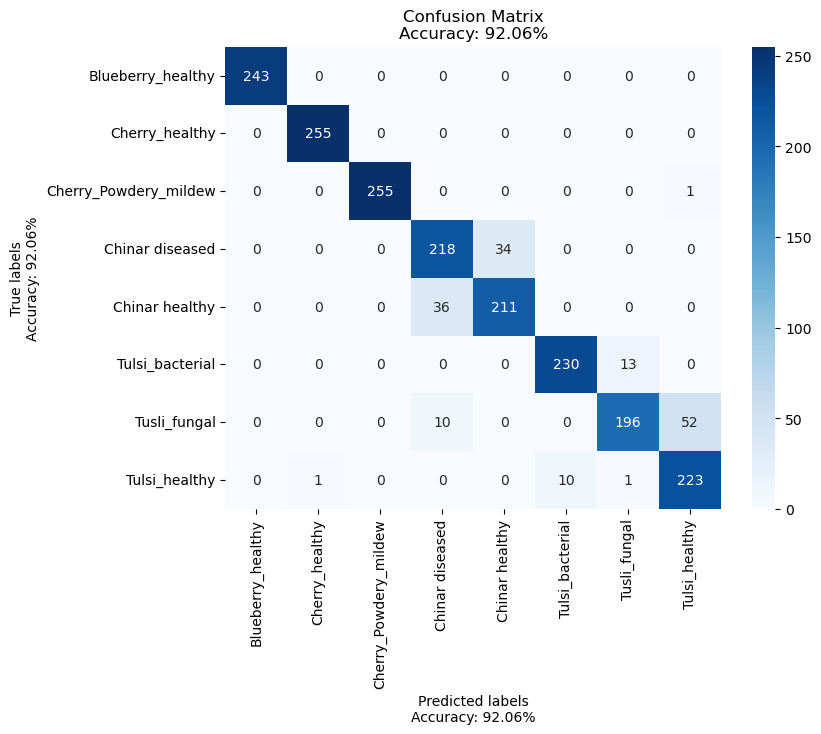

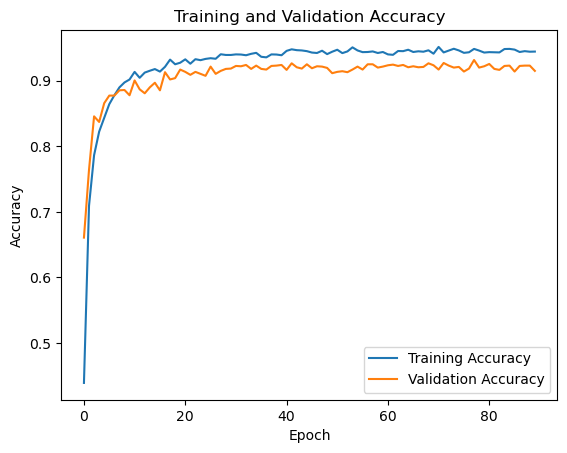

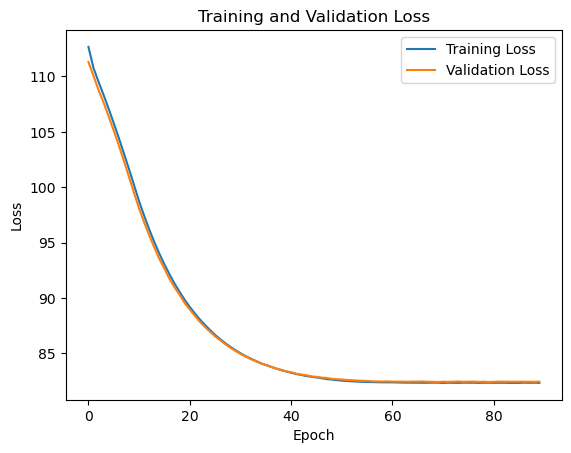

Predicted class name: Blueberry_healthy
Classification Report:
                        precision    recall  f1-score   support

    Blueberry_healthy       1.00      1.00      1.00       243
       Cherry_healthy       1.00      1.00      1.00       255
Cherry_Powdery_mildew       1.00      1.00      1.00       256
      Chinar diseased       0.83      0.87      0.84       252
       Chinar healthy       0.86      0.85      0.86       247
      Tulsi_bacterial       0.96      0.95      0.95       243
         Tusli_fungal       0.93      0.76      0.84       258
        Tulsi_healthy       0.81      0.95      0.87       235

             accuracy                           0.92      1989
            macro avg       0.92      0.92      0.92      1989
         weighted avg       0.92      0.92      0.92      1989



In [1]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
import tensorflow as tf

# Define classes
classes = ["Blueberry_healthy","Cherry_healthy","Cherry_Powdery_mildew","Chinar diseased","Chinar healthy","Tulsi_bacterial","Tusli_fungal","Tulsi_healthy"]
data_dir = r"C:\Users\user7\Desktop\Crop Doctor\model 5\Dataset"

# Enhanced data augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.3
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='sparse',
    shuffle=True,
    subset='training'
)

test_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='sparse',
    shuffle=False,
    subset='validation'
)

vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze more layers
for layer in vgg_model.layers[:10]:
    layer.trainable = False
for layer in vgg_model.layers[10:]:
    layer.trainable = True

# Add custom layers with batch normalization and L2 regularization
x = layers.Flatten()(vgg_model.output)
x = layers.BatchNormalization()(x)
x = layers.Dense(4096, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), name='fc6')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(4096, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01), name='fc7')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(len(classes), activation='softmax', name='predictions')(x)

model = models.Model(vgg_model.input, output)

# Compile the model with AdamW optimizer
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.00001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    elif epoch < 50:
        return lr * tf.math.exp(-0.1)
    else:
        return lr * tf.math.exp(-0.2)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model_vgg16.h5', save_best_only=True, monitor='val_accuracy', mode='max')

history = model.fit(
    train_generator,
    epochs=100,
    validation_data=test_generator,
    callbacks=[lr_callback, early_stopping, model_checkpoint]
)

# Load the best model
model = tf.keras.models.load_model('best_model_vgg16.h5')

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

# Save the model in HDF5 format
model.save('my_model5.h5', save_format='h5')

# Confusion matrix and classification report
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = np.argmax(model.predict(test_generator), axis=1)
y_true = test_generator.classes

conf_matrix = confusion_matrix(y_true, y_pred)
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
accuracy_percentage = accuracy * 100

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel(f'Predicted labels\nAccuracy: {accuracy_percentage:.2f}%')
plt.ylabel(f'True labels\nAccuracy: {accuracy_percentage:.2f}%')
plt.title(f'Confusion Matrix\nAccuracy: {accuracy_percentage:.2f}%')
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

predicted_class_name = classes[y_pred[3]]
print("Predicted class name:", predicted_class_name)

classification_rep = classification_report(y_true, y_pred, target_names=classes)
print("Classification Report:\n", classification_rep)
